# Code lab for Skripsi (Refined)

This branch implements the real world scenario of feature selection-train-cross validate-test sequence, so that the validation data does not get leaked by the feature selection method.

Feature extraction part is done in `deep_feature_extractior.ipynb` files. This file is used to feature selection and train model

In [4]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt

import joblib

In [20]:
df = pd.read_parquet('data/orig_img_feature.parquet')

In [21]:
file_name = df.pop('file_name')
label = df.pop('is_infected')

In [22]:
# split data
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.2, random_state=42)

## Hyperparameter tuning with Cross Validation

Find Hyperparameter C with cross validation and will be using k=10. Metrics being used is F1-Score, Recall, Precision, and Accuracy.

### With Feature Selection

In [11]:
svc_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
METRICS = ['f1', 'recall', 'precision', 'accuracy']
cv_results = []

for c in svc_C:
    svm = SVC(kernel='linear', C=c, random_state=42)
    selector = SelectFromModel(svm)
    pipeline = make_pipeline(selector, svm)
    # pipeline.fit(X_train, y_train)
    cv_result = cross_validate(pipeline, X_train, y_train, cv=5, scoring=METRICS)
    cv_results.append(cv_result)
    print('C =', c)
    # print('Threshold :', pipeline['selectfrommodel'].threshold_)
    # print('No. selected feature :', pipeline['selectfrommodel'].get_feature_names_out().shape)
    # print('Accuracy :', pipeline.score(X_test, y_test))
    print('-------------------------\n')

C = 0.001
-------------------------
C = 0.01
-------------------------
C = 0.1
-------------------------
C = 1
-------------------------
C = 10
-------------------------
C = 100
-------------------------
C = 1000
-------------------------


In [34]:
results_array = []
for i in range(len(cv_results)):
    results_array.append(np.concatenate(list(cv_results[i].values())))
results_array = np.vstack(results_array)

columns_list = [f'split{i}_{x}' for x in cv_results[0].keys() for i in range(5)]
cv_results_df = pd.DataFrame(results_array,
                             columns=columns_list)
cv_results_df

,split0_fit_time,split1_fit_time,split2_fit_time,split3_fit_time,split4_fit_time,split0_score_time,split1_score_time,split2_score_time,split3_score_time,split4_score_time,...,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy
0,172.019574,167.803654,162.506551,163.994127,161.380582,15.560406,15.378515,15.038853,15.322293,14.995886,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
1,162.848231,162.564057,163.826032,173.402894,170.724461,15.260124,15.308259,15.130209,16.060339,15.436579,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
2,169.372138,170.339452,172.216739,174.114386,180.542132,15.537602,15.758531,15.739427,16.001642,17.975934,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
3,188.400851,186.494906,183.164107,188.324466,184.614994,17.048309,18.610208,16.748530,16.827398,16.086066,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
4,179.020320,169.538297,168.180514,167.380631,169.486408,16.009531,15.600528,15.234541,16.093523,16.270541,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
5,172.904278,171.758564,167.034236,172.737628,295.692074,15.779090,15.527566,15.236147,16.185142,22.361372,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375
6,216.557693,201.053431,189.831080,178.342986,175.809031,17.711566,17.529551,15.768149,16.039544,15.569001,...,0.837662,0.84106,0.793939,0.822086,0.856115,0.821875,0.821875,0.803125,0.828125,0.809375


In [37]:
cv_results_df.insert(0, 'C', svc_C)
cv_results_df['mean_fit_time'] = cv_results_df[['split0_fit_time', 'split1_fit_time', 'split2_fit_time', 'split3_fit_time', 'split4_fit_time']].mean(axis=1)
cv_results_df['mean_score_time'] = cv_results_df[['split0_score_time', 'split1_score_time', 'split2_score_time', 'split3_score_time', 'split4_score_time']].mean(axis=1)
cv_results_df['mean_test_f1'] = cv_results_df[['split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1']].mean(axis=1)
cv_results_df['mean_test_recall'] = cv_results_df[['split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_test_recall', 'split4_test_recall']].mean(axis=1)
cv_results_df['mean_test_precision'] = cv_results_df[['split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision']].mean(axis=1)
cv_results_df['mean_test_accuracy'] = cv_results_df[['split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy']].mean(axis=1)
cv_results_df

,C,split0_fit_time,split1_fit_time,split2_fit_time,split3_fit_time,split4_fit_time,split0_score_time,split1_score_time,split2_score_time,split3_score_time,...,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_fit_time,mean_score_time,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
0,0.001,172.019574,167.803654,162.506551,163.994127,161.380582,15.560406,15.378515,15.038853,15.322293,...,0.821875,0.803125,0.828125,0.809375,165.540898,15.259191,0.813526,0.798998,0.830172,0.816875
1,0.010,162.848231,162.564057,163.826032,173.402894,170.724461,15.260124,15.308259,15.130209,16.060339,...,0.821875,0.803125,0.828125,0.809375,166.673135,15.439102,0.813526,0.798998,0.830172,0.816875
2,0.100,169.372138,170.339452,172.216739,174.114386,180.542132,15.537602,15.758531,15.739427,16.001642,...,0.821875,0.803125,0.828125,0.809375,173.316970,16.202627,0.813526,0.798998,0.830172,0.816875
3,1.000,188.400851,186.494906,183.164107,188.324466,184.614994,17.048309,18.610208,16.748530,16.827398,...,0.821875,0.803125,0.828125,0.809375,186.199865,17.064102,0.813526,0.798998,0.830172,0.816875
4,10.000,179.020320,169.538297,168.180514,167.380631,169.486408,16.009531,15.600528,15.234541,16.093523,...,0.821875,0.803125,0.828125,0.809375,170.721234,15.841733,0.813526,0.798998,0.830172,0.816875
5,100.000,172.904278,171.758564,167.034236,172.737628,295.692074,15.779090,15.527566,15.236147,16.185142,...,0.821875,0.803125,0.828125,0.809375,196.025356,17.017863,0.813526,0.798998,0.830172,0.816875
6,1000.000,216.557693,201.053431,189.831080,178.342986,175.809031,17.711566,17.529551,15.768149,16.039544,...,0.821875,0.803125,0.828125,0.809375,192.318844,16.523562,0.813526,0.798998,0.830172,0.816875


In [38]:
cv_results_df.to_csv(r'result\cv_results_fs.tsv', sep='\t', index=False)
cv_results_df[['C', 'mean_fit_time', 'mean_test_f1', 'mean_test_recall', 'mean_test_precision', 'mean_test_accuracy']]

,C,mean_fit_time,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
0,0.001,165.540898,0.813526,0.798998,0.830172,0.816875
1,0.010,166.673135,0.813526,0.798998,0.830172,0.816875
2,0.100,173.316970,0.813526,0.798998,0.830172,0.816875
3,1.000,186.199865,0.813526,0.798998,0.830172,0.816875
4,10.000,170.721234,0.813526,0.798998,0.830172,0.816875
5,100.000,196.025356,0.813526,0.798998,0.830172,0.816875
6,1000.000,192.318844,0.813526,0.798998,0.830172,0.816875


#### With Different Threshold

In [33]:
PARAM_GRID = {
    'selectfrommodel__threshold': ['median', 'mean'],
    'svc__C': svc_C
}

grid = GridSearchCV(
    make_pipeline(SelectFromModel(SVC(kernel='linear', random_state=42)),
                  SVC(kernel='linear', random_state=42)),
    cv=5,
    param_grid=PARAM_GRID,
    scoring=METRICS,
    refit=False,
    verbose=3,
    n_jobs=3
)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectfrommodel',
                                        SelectFromModel(estimator=SVC(kernel='linear',
                                                                      random_state=42))),
                                       ('svc',
                                        SVC(kernel='linear',
                                            random_state=42))]),
             n_jobs=3,
             param_grid={'selectfrommodel__threshold': ['median', 'mean'],
                         'svc__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             refit=False, scoring=['f1', 'recall', 'precision', 'accuracy'],
             verbose=3)

In [35]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selectfrommodel__threshold,param_svc__C,params,split0_test_f1,split1_test_f1,split2_test_f1,...,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,140.874095,2.173206,9.454942,0.246573,median,0.001,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
1,137.068109,1.861415,9.439970,0.259842,median,0.01,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
2,135.226752,1.202863,10.090891,0.755222,median,0.1,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
3,146.502533,8.051628,9.789306,0.224660,median,1,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
4,142.628306,10.414513,10.317771,0.979422,median,10,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
5,161.569926,2.957687,11.654606,0.723967,median,100,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
6,161.192413,6.122381,10.598723,0.728030,median,1000,"{'selectfrommodel__threshold': 'median', 'svc_...",0.823899,0.817891,0.806154,...,0.020764,8,0.825000,0.821875,0.803125,0.828125,0.812500,0.818125,0.009143,1
7,139.115029,9.410259,7.778150,0.731643,mean,0.001,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.819048,0.816720,0.806154,...,0.021099,1,0.821875,0.821875,0.803125,0.828125,0.809375,0.816875,0.009186,8
8,121.577390,0.721674,7.660295,0.346042,mean,0.01,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.819048,0.816720,0.806154,...,0.021099,1,0.821875,0.821875,0.803125,0.828125,0.809375,0.816875,0.009186,8
9,121.559452,0.652586,7.533047,0.211295,mean,0.1,"{'selectfrommodel__threshold': 'mean', 'svc__C...",0.819048,0.816720,0.806154,...,0.021099,1,0.821875,0.821875,0.803125,0.828125,0.809375,0.816875,0.009186,8


### Without Feature Selection

In [ ]:
PARAM_GRID = {'C': svc_C}

grid_no_fs = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    cv=5,
    param_grid=PARAM_GRID,
    scoring=METRICS,
    refit=False,
    verbose=3
)
grid_no_fs.fit(X_train, y_train)

In [40]:
cv_result_no_fs = pd.DataFrame(grid_no_fs.cv_results_)
cv_result_no_fs.to_csv(r'result\cv_result_no_fs.tsv', sep='\t', index=False)
cv_result_no_fs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,...,std_test_precision,rank_test_precision,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,88.802842,0.944986,16.622678,0.262505,0.001,{'C': 0.001},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
1,86.668458,0.498128,16.472115,0.216653,0.01,{'C': 0.01},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
2,85.676329,0.682434,16.501517,0.196086,0.1,{'C': 0.1},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
3,88.654822,2.457385,16.551476,0.416479,1,{'C': 1},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
4,88.119997,1.343442,17.029122,0.641395,10,{'C': 10},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
5,88.769875,2.984865,16.633774,0.619866,100,{'C': 100},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1
6,84.894957,1.007263,16.099048,0.207735,1000,{'C': 1000},0.821317,0.824281,0.8,0.829721,...,0.023342,1,0.821875,0.828125,0.796875,0.828125,0.8125,0.8175,0.011792,1


In [41]:
cv_result_no_fs[['param_C', 'mean_fit_time', 'mean_test_f1', 'mean_test_precision', 'mean_test_recall', 'mean_test_accuracy']]

,param_C,mean_fit_time,mean_test_f1,mean_test_precision,mean_test_recall,mean_test_accuracy
0,0.001,88.802842,0.815064,0.827872,0.803983,0.8175
1,0.01,86.668458,0.815064,0.827872,0.803983,0.8175
2,0.1,85.676329,0.815064,0.827872,0.803983,0.8175
3,1,88.654822,0.815064,0.827872,0.803983,0.8175
4,10,88.119997,0.815064,0.827872,0.803983,0.8175
5,100,88.769875,0.815064,0.827872,0.803983,0.8175
6,1000,84.894957,0.815064,0.827872,0.803983,0.8175


## Build and run the model

Because all metrics are the same on all C, we train it using the C that provide the least fit time, that is C=0.1

In [36]:
best_param_svm = SVC(kernel="linear", C=0.001, random_state=42)
best_selector = SelectFromModel(best_param_svm)
new_pipeline = make_pipeline(best_selector,
                             best_param_svm)
new_pipeline.fit(X_train, y_train)

Pipeline(steps=[('selectfrommodel',
                 SelectFromModel(estimator=SVC(C=0.001, kernel='linear',
                                               random_state=42))),
                ('svc', SVC(C=0.001, kernel='linear', random_state=42))])

In [37]:
joblib.dump(new_pipeline, r'dumps\pipeline.joblib')

['dumps\\pipeline.joblib']

### Calculate Threshold Manually

Train SVM on all X_train to calculate the threshold manually

In [38]:
train_svm = SVC(kernel='linear', C=0.001)
train_svm.fit(X_train, y_train)

SVC(C=0.001, kernel='linear')

In [39]:
np.savetxt(r'data\svm_coef.txt', train_svm.coef_, delimiter='\n')

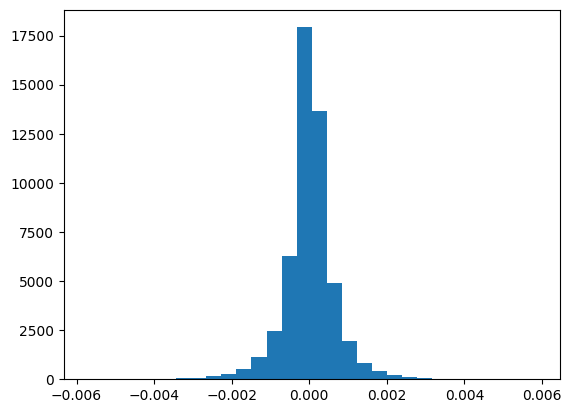

In [40]:
coef = np.loadtxt(r'data\svm_coef.txt')
plt.hist(coef, bins=30)
plt.show()

(array([1660., 1620., 1936., 1832., 2026., 1912., 1735., 1791., 1432.,
        1567.]),
 array([    0. ,  5119.7, 10239.4, 15359.1, 20478.8, 25598.5, 30718.2,
        35837.9, 40957.6, 46077.3, 51197. ]),
 <BarContainer object of 10 artists>)

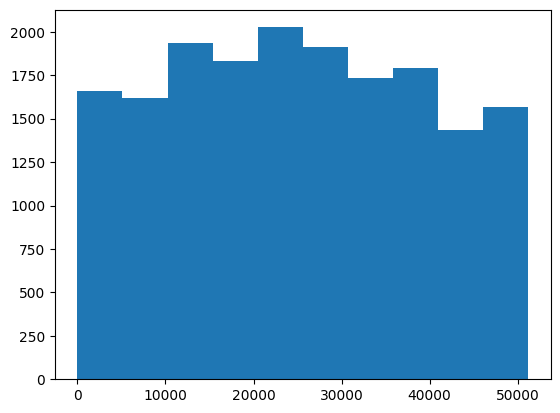

In [41]:
plt.hist(np.where(np.abs(coef) > np.abs(coef).mean())[0])

In [42]:
print('Threshold:', np.abs(train_svm.coef_).mean())

Threshold: 0.0004338642829973967


### Get Selector and Estimator Properties

In [43]:
print('Threshold :', new_pipeline['selectfrommodel'].threshold_)

Threshold : 0.0004338642829973967


In [44]:
print('No. selected feature :', new_pipeline['selectfrommodel'].get_feature_names_out().shape)

No. selected feature : (17511,)


In [45]:
np.savetxt(r'data\svm_coef_selected.txt', new_pipeline['svc'].coef_, delimiter='\n')

## Evaluate Model

Evaluate model on test data using same metrics from cross-validation.

In [5]:
# new_pipeline = joblib.load(r'dumps\pipeline.joblib')

In [46]:
y_pred = new_pipeline.predict(X_test)
true_pred_df = pd.DataFrame({'file_name': file_name[X_test.index],
                             'y_true': np.where(y_test == 0, 'normal', 'terinfeksi'),
                             'y_pred': np.where(y_pred == 0, 'normal', 'terinfeksi')})
true_pred_df.to_csv(r'result\true_pred.csv', index=False)
true_pred_df

,file_name,y_true,y_pred
1860,DSC04798_4.JPG,normal,normal
353,DSC04353_4.JPG,terinfeksi,terinfeksi
1333,DSC04273_8.JPG,normal,normal
905,DSC04721_6.JPG,terinfeksi,terinfeksi
1289,DSC04254_9.JPG,normal,normal
...,...,...,...
965,DSC04793_5.JPG,terinfeksi,normal
1284,DSC04253_7.JPG,normal,normal
1739,DSC04633_1.JPG,normal,normal
261,DSC04249_9.JPG,terinfeksi,terinfeksi


[[166  35]
 [ 45 154]]


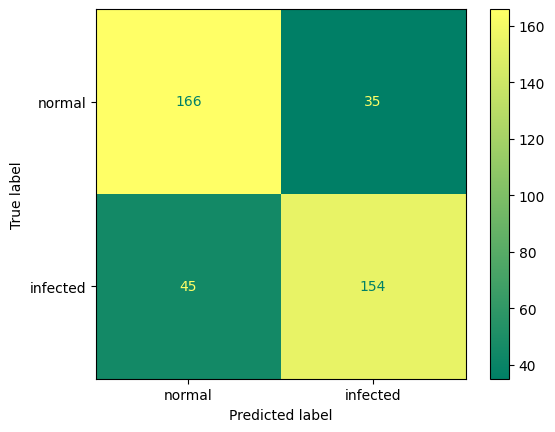

In [47]:
y_pred = new_pipeline.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred))
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['normal', 'infected'], cmap='summer')

In [48]:
metrics_list = [metrics.f1_score,
                metrics.accuracy_score,
                metrics.precision_score,
                metrics.recall_score]

for metric in metrics_list:
    print(metric.__name__ + ':', metric(y_test, y_pred))

f1_score: 0.7938144329896907
accuracy_score: 0.8
precision_score: 0.8148148148148148
recall_score: 0.7738693467336684
